In [ ]:
# --- Imports ---
import os
import numpy as np
import math
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

train_noisy_dir = "/kaggle/input/dlp-jan-2025-nppe-3/archive/train/train"
train_gt_dir = "/kaggle/input/dlp-jan-2025-nppe-3/archive/train/gt"
val_noisy_dir = "/kaggle/input/dlp-jan-2025-nppe-3/archive/val/val"
val_gt_dir = "/kaggle/input/dlp-jan-2025-nppe-3/archive/val/gt"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 4
EPOCHS = 20
LR = 5e-4


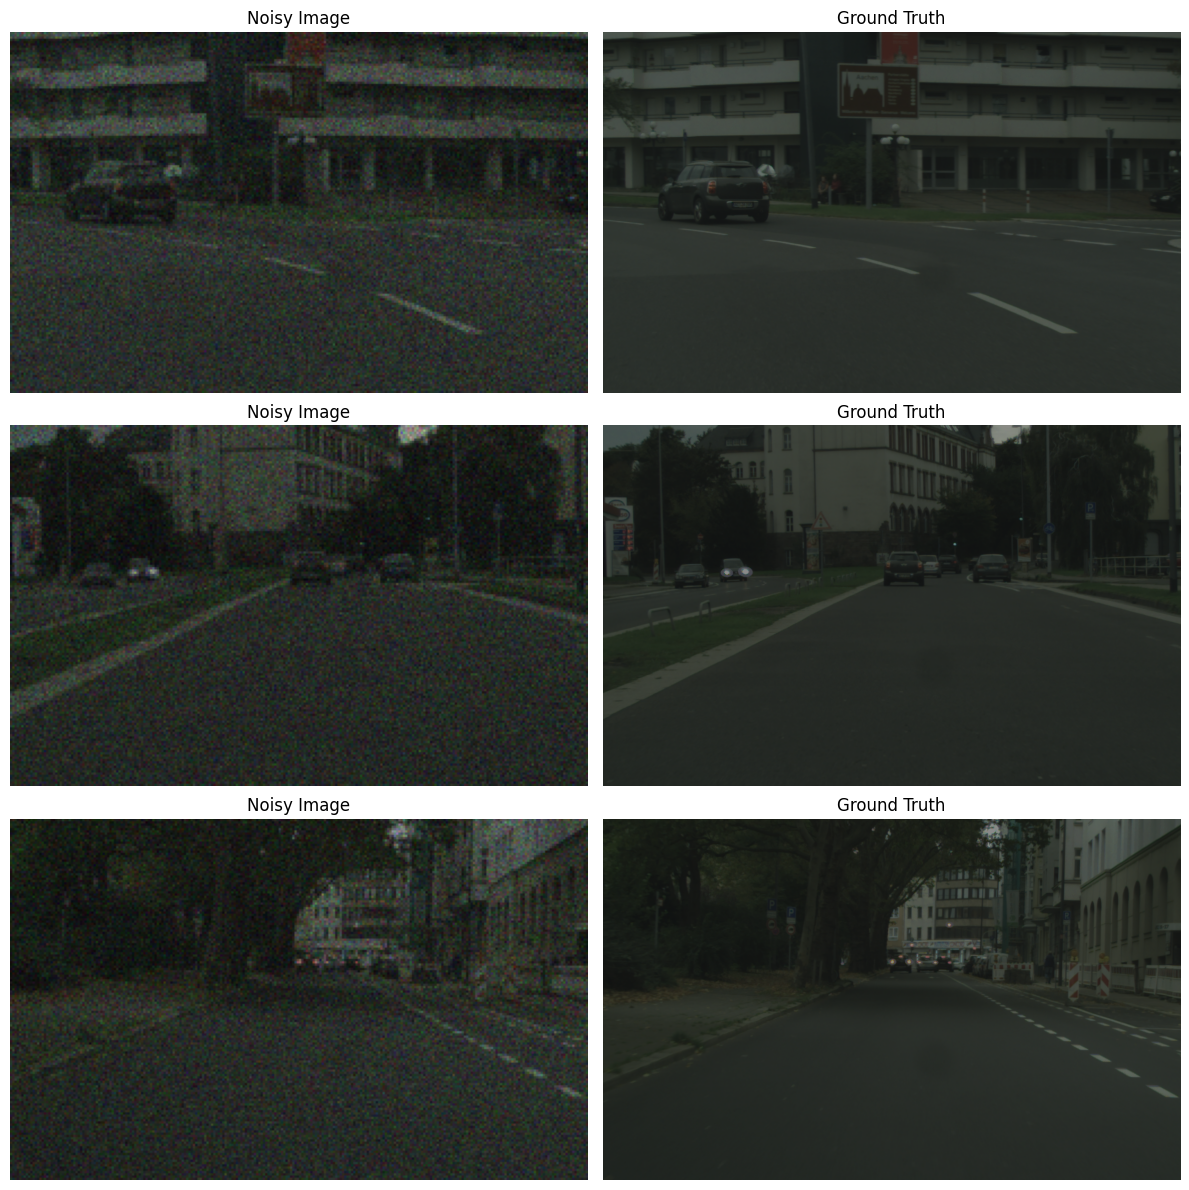

In [2]:
def show_samples(noisy_dir, gt_dir, count=3):
    noisy_files = sorted(os.listdir(noisy_dir))[:count]
    plt.figure(figsize=(12, 4 * count))
    for i, file in enumerate(noisy_files):
        noisy_img = Image.open(os.path.join(noisy_dir, file)).convert("RGB")
        gt_name = file.replace("val", "gt").replace("train", "gt")
        gt_img = Image.open(os.path.join(gt_dir, gt_name)).convert("RGB")
        
        plt.subplot(count, 2, 2*i + 1)
        plt.imshow(noisy_img)
        plt.title("Noisy Image")
        plt.axis('off')

        plt.subplot(count, 2, 2*i + 2)
        plt.imshow(gt_img)
        plt.title("Ground Truth")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Show training samples
show_samples(train_noisy_dir, train_gt_dir)


In [3]:
# --- PSNR Metric ---
def calculate_psnr(img1, img2):
    img1 = img1.astype(np.float32)
    img2 = img2.astype(np.float32)
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * math.log10(255.0 / math.sqrt(mse))

# --- Custom Dataset ---
class SuperResDataset(Dataset):
    def __init__(self, noisy_dir, gt_dir):
        self.noisy_images = sorted(os.listdir(noisy_dir))
        self.noisy_dir = noisy_dir
        self.gt_dir = gt_dir
        self.transform = transforms.ToTensor()

    def __len__(self):
        return len(self.noisy_images)

    def __getitem__(self, idx):
        noisy_path = os.path.join(self.noisy_dir, self.noisy_images[idx])
        gt_name = self.noisy_images[idx].replace("val", "gt").replace("train", "gt")
        gt_path = os.path.join(self.gt_dir, gt_name)

        try:
            noisy_img = Image.open(noisy_path).convert("RGB")
            gt_img = Image.open(gt_path).convert("RGB")
        except:
            return torch.zeros(3, 4, 4), torch.zeros(3, 4, 4)

        if noisy_img.size[0] < 16 or noisy_img.size[1] < 16:
            return torch.zeros(3, 4, 4), torch.zeros(3, 4, 4)

        return self.transform(noisy_img), self.transform(gt_img)

# --- Load Datasets ---
train_dataset = SuperResDataset(train_noisy_dir, train_gt_dir)
val_dataset = SuperResDataset(val_noisy_dir, val_gt_dir)

# Remove bad samples
train_dataset = [x for x in train_dataset if x[0].shape[1] > 4]
val_dataset = [x for x in val_dataset if x[0].shape[1] > 4]

# --- DataLoaders ---
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)


In [4]:
# --- Denoising Network (DnCNN) ---
class DnCNN(nn.Module):
    def __init__(self, channels=3, num_layers=17):
        super(DnCNN, self).__init__()
        layers = [nn.Conv2d(channels, 64, 3, padding=1), nn.ReLU(inplace=True)]
        for _ in range(num_layers - 2):
            layers += [nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True)]
        layers += [nn.Conv2d(64, channels, 3, padding=1)]
        self.dncnn = nn.Sequential(*layers)

    def forward(self, x):
        return x - self.dncnn(x)

# --- Super-Resolution Network (EDSR) ---
class ResBlock(nn.Module):
    def __init__(self, num_feats):
        super(ResBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(num_feats, num_feats, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(num_feats, num_feats, 3, padding=1)
        )

    def forward(self, x):
        return x + self.block(x)

class EDSR(nn.Module):
    def __init__(self, in_channels=3, num_feats=64, num_blocks=16):
        super(EDSR, self).__init__()
        self.head = nn.Conv2d(in_channels, num_feats, 3, padding=1)
        self.body = nn.Sequential(*[ResBlock(num_feats) for _ in range(num_blocks)])
        self.tail = nn.Sequential(
            nn.Conv2d(num_feats, num_feats * 4, 3, padding=1),
            nn.PixelShuffle(2),
            nn.ReLU(),
            nn.Conv2d(num_feats, num_feats * 4, 3, padding=1),
            nn.PixelShuffle(2),
            nn.ReLU(),
            nn.Conv2d(num_feats, in_channels, 3, padding=1)
        )

    def forward(self, x):
        x = self.head(x)
        res = self.body(x)
        return self.tail(res + x)


In [ ]:
# --- Initialize Models ---
denoiser = DnCNN().to(device)
sr_model = EDSR().to(device)

# --- Loss Function & Optimizer ---
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(list(denoiser.parameters()) + list(sr_model.parameters()), lr=LR)


In [2]:
# --- Training ---
for epoch in range(EPOCHS):
    denoiser.train()
    sr_model.train()
    total_loss = 0
    for noisy, gt in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        noisy, gt = noisy.to(device), gt.to(device)
        denoised = denoiser(noisy)
        output = sr_model(denoised)
        loss = criterion(output, gt)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}: Loss = {total_loss / len(train_loader):.4f}")

    # --- Validation ---
    denoiser.eval()
    sr_model.eval()
    total_psnr = 0
    with torch.no_grad():
        for noisy, gt in val_loader:
            noisy, gt = noisy.to(device), gt.to(device)
            denoised = denoiser(noisy)
            output = sr_model(denoised).clamp(0, 1)
            output_np = output.squeeze().permute(1, 2, 0).cpu().numpy() * 255
            gt_np = gt.squeeze().permute(1, 2, 0).cpu().numpy() * 255
            total_psnr += calculate_psnr(output_np, gt_np)
    print(f"Validation PSNR: {total_psnr / len(val_loader):.2f} dB")


Epoch 1/10: 100%|██████████| 277/277 [05:07<00:00,  1.11s/it]


Epoch 1: Loss = 0.0266
Validation PSNR: 35.49 dB


Epoch 2/10: 100%|██████████| 277/277 [05:10<00:00,  1.12s/it]


Epoch 2: Loss = 0.0143
Validation PSNR: 36.21 dB


Epoch 3/10: 100%|██████████| 277/277 [05:10<00:00,  1.12s/it]


Epoch 3: Loss = 0.0118
Validation PSNR: 37.37 dB


Epoch 4/10: 100%|██████████| 277/277 [05:10<00:00,  1.12s/it]


Epoch 4: Loss = 0.0112
Validation PSNR: 37.69 dB


Epoch 5/10: 100%|██████████| 277/277 [05:10<00:00,  1.12s/it]


Epoch 5: Loss = 0.0109
Validation PSNR: 37.89 dB


Epoch 6/10: 100%|██████████| 277/277 [05:11<00:00,  1.12s/it]


Epoch 6: Loss = 0.0106
Validation PSNR: 38.53 dB


Epoch 7/10: 100%|██████████| 277/277 [05:11<00:00,  1.12s/it]


Epoch 7: Loss = 0.0105
Validation PSNR: 37.86 dB


Epoch 8/10: 100%|██████████| 277/277 [05:11<00:00,  1.12s/it]


Epoch 8: Loss = 0.0112
Validation PSNR: 37.88 dB


Epoch 9/10: 100%|██████████| 277/277 [05:03<00:00,  1.09s/it]


Epoch 9: Loss = 0.1155
Validation PSNR: 25.04 dB


Epoch 10/10: 100%|██████████| 277/277 [04:55<00:00,  1.07s/it]


Epoch 10: Loss = 0.0561
Validation PSNR: 23.81 dB


In [4]:
# Save models at each epoch (or only final if you prefer)
torch.save(denoiser.state_dict(), "denoiser.pth")
torch.save(sr_model.state_dict(), "sr_model.pth")
print("✅ Models saved as denoiser.pth and sr_model.pth")


✅ Models saved as denoiser.pth and sr_model.pth


In [5]:
#test evaluation
import os
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import torch
import torchvision.transforms as transforms

# --- Config ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_dir = "/kaggle/input/dlp-jan-2025-nppe-3/archive/test"
output_folder = "/kaggle/working/"
os.makedirs(output_folder, exist_ok=True)

# --- Define Models (must match training code) ---
import torch.nn as nn

class DnCNN(nn.Module):
    def __init__(self, channels=3, num_layers=17):
        super(DnCNN, self).__init__()
        layers = [nn.Conv2d(channels, 64, 3, padding=1), nn.ReLU(inplace=True)]
        for _ in range(num_layers - 2):
            layers += [nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True)]
        layers += [nn.Conv2d(64, channels, 3, padding=1)]
        self.dncnn = nn.Sequential(*layers)

    def forward(self, x):
        noise = self.dncnn(x)
        return x - noise

class ResBlock(nn.Module):
    def __init__(self, num_feats):
        super(ResBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(num_feats, num_feats, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(num_feats, num_feats, 3, padding=1)
        )

    def forward(self, x):
        return x + self.block(x)

class EDSR(nn.Module):
    def __init__(self, in_channels=3, num_feats=64, num_blocks=32):
        super(EDSR, self).__init__()
        self.head = nn.Conv2d(in_channels, num_feats, 3, padding=1)
        self.body = nn.Sequential(*[ResBlock(num_feats) for _ in range(num_blocks)])
        self.tail = nn.Sequential(
            nn.Conv2d(num_feats, num_feats * 4, 3, padding=1),
            nn.PixelShuffle(2),
            nn.ReLU(),
            nn.Conv2d(num_feats, num_feats * 4, 3, padding=1),
            nn.PixelShuffle(2),
            nn.ReLU(),
            nn.Conv2d(num_feats, in_channels, 3, padding=1)
        )

    def forward(self, x):
        x = self.head(x)
        res = self.body(x)
        return self.tail(res + x)

# --- Load models ---
denoiser = DnCNN().to(device)
sr_model = EDSR().to(device)
denoiser.load_state_dict(torch.load("denoiser.pth", map_location=device))
sr_model.load_state_dict(torch.load("sr_model.pth", map_location=device))
denoiser.eval()
sr_model.eval()

# --- Transforms ---
to_tensor = transforms.ToTensor()
to_pil = transforms.ToPILImage()

# --- Inference ---
for filename in tqdm(sorted(os.listdir(test_dir)), desc="Processing test images"):
    if filename.endswith(('.png', '.jpg', '.jpeg')):
        img_path = os.path.join(test_dir, filename)
        image = Image.open(img_path).convert("RGB")
        input_tensor = to_tensor(image).unsqueeze(0).to(device)

        with torch.no_grad():
            denoised = denoiser(input_tensor)
            sr_output = sr_model(denoised).clamp(0, 1)

        output_img = to_pil(sr_output.squeeze(0).cpu()).convert("L")
        output_img.save(os.path.join(output_folder, filename))

print("✅ All images processed and saved to", output_folder)

# --- Convert images to CSV ---
def images_to_csv(folder_path, output_csv):
    data_rows = []
    for filename in sorted(os.listdir(folder_path)):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            image_path = os.path.join(folder_path, filename)
            image = Image.open(image_path).convert('L')
            image_array = np.array(image).flatten()[::8]  # sample every 8th pixel
            image_id = filename.split('.')[0].replace('test_', 'gt_')
            data_rows.append([image_id, *image_array])
    
    column_names = ['ID'] + [f'pixel_{i}' for i in range(len(data_rows[0]) - 1)]
    df = pd.DataFrame(data_rows, columns=column_names)
    df.to_csv(output_csv, index=False)
    print(f"✅ Successfully saved submission CSV to: {output_csv}")

images_to_csv(output_folder, "submission.csv")


<ipython-input-5-f28bf6e4e5c2>:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  denoiser.load_state_dict(torch.load("denoiser.pth", map_location=device))
<ipython-input-5-f

✅ All images processed and saved to /kaggle/working/
✅ Successfully saved submission CSV to: submission.csv
